# Stock NeurIPS2018 Part 3. Backtest
This series is a reproduction of paper *the process in the paper Practical Deep Reinforcement Learning Approach for Stock Trading*. 

This is the third and last part of the NeurIPS2018 series, introducing how to use use the agents we trained to do backtest, and compare with baselines such as Mean Variance Optimization and DJIA index.

Other demos can be found at the repo of [FinRL-Tutorials]((https://github.com/AI4Finance-Foundation/FinRL-Tutorials)).

# Part 1. Install Packages

In [1]:
## install finrl library
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

%matplotlib inline

# Part 2. Backtesting

To backtest the agents, upload trade_data.csv in the same directory of this notebook. For Colab users, just upload trade_data.csv to the default directory.

In [3]:
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following lines.
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

Then, upload the trained agent to the same directory, and set the corresponding variable to True.

In [4]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

Load the agents

In [5]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

/home/cksgh8511/anaconda3/envs/finrl38/lib/python3.8/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/home/cksgh8511/anaconda3/envs/finrl38/lib/python3.8/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `dev

FileNotFoundError: [Errno 2] No such file or directory: 'trained_models/agent_sac.zip'

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [ ]:
df_account_value_a2c

,date,account_value
0,2020-07-01,1.000000e+06
1,2020-07-02,1.000316e+06
2,2020-07-06,1.003272e+06
3,2020-07-07,1.000177e+06
4,2020-07-08,1.002810e+06
...,...,...
1216,2025-05-05,2.011779e+06
1217,2025-05-06,1.999502e+06
1218,2025-05-07,2.015185e+06
1219,2025-05-08,2.032323e+06


In [ ]:
df_actions_a2c

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0,0,0,0,52,100,14,0,12,0,...,8,0,64,0,84,0,16,100,26,100
2020-07-02,0,0,0,0,52,100,14,0,12,0,...,8,0,64,0,84,0,16,100,26,100
2020-07-06,0,0,0,0,52,100,14,0,12,0,...,8,0,64,0,84,0,16,100,26,100
2020-07-07,0,0,0,0,52,100,14,0,12,0,...,8,0,64,0,84,0,16,100,26,100
2020-07-08,0,0,0,0,52,100,14,0,12,0,...,8,0,64,0,84,0,16,100,26,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-05-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-05-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
trade[trade['tic']=='WMT']['close']


0       37.149754
1       37.000771
2       36.901451
3       39.403133
4       38.624073
          ...    
1216    99.090424
1217    98.312302
1218    98.591629
1219    97.195000
1220    96.720001
Name: close, Length: 1221, dtype: float64

In [ ]:
df_actions_a2c.WMT

date
2020-07-01    100
2020-07-02    100
2020-07-06    100
2020-07-07    100
2020-07-08    100
             ... 
2025-05-02      0
2025-05-05      0
2025-05-06      0
2025-05-07      0
2025-05-08      0
Name: WMT, Length: 1220, dtype: int64

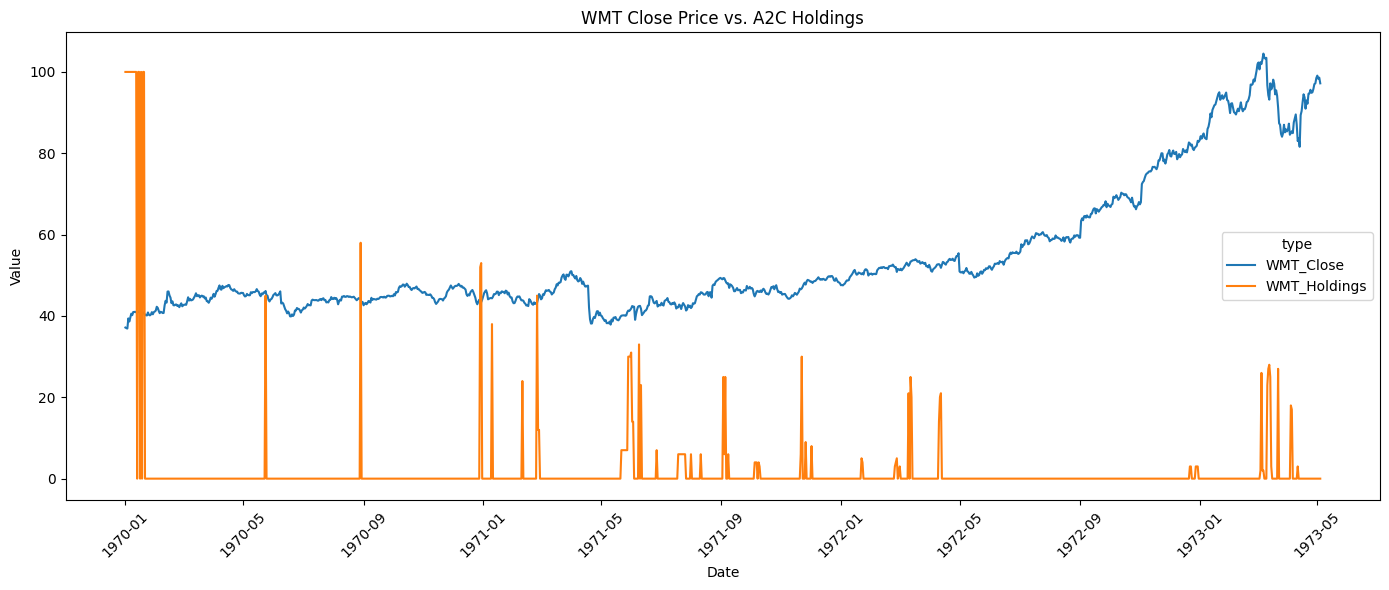

In [ ]:
import  pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# 공통 날짜 정렬
common_dates = df_actions_a2c.index.intersection(trade[trade['tic'] == 'WMT']['date'])
wmt_trade = trade[trade['tic'] == 'WMT'].set_index('date')
wmt_close = wmt_trade.loc[common_dates]['close']
wmt_holdings = df_actions_a2c.loc[common_dates]['WMT']

# 데이터프레임 통합
df_plot = pd.DataFrame({
    'date': common_dates,
    'WMT_Close': wmt_close.values,
    'WMT_Holdings': wmt_holdings.values
})

# melt 형태로 변환 (Seaborn용)
df_melted = df_plot.melt(id_vars='date', var_name='type', value_name='value')

# 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_melted, x='date', y='value', hue='type')

# 날짜 포맷 자동 간격
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('WMT Close Price vs. A2C Holdings')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Axes: xlabel='date'>

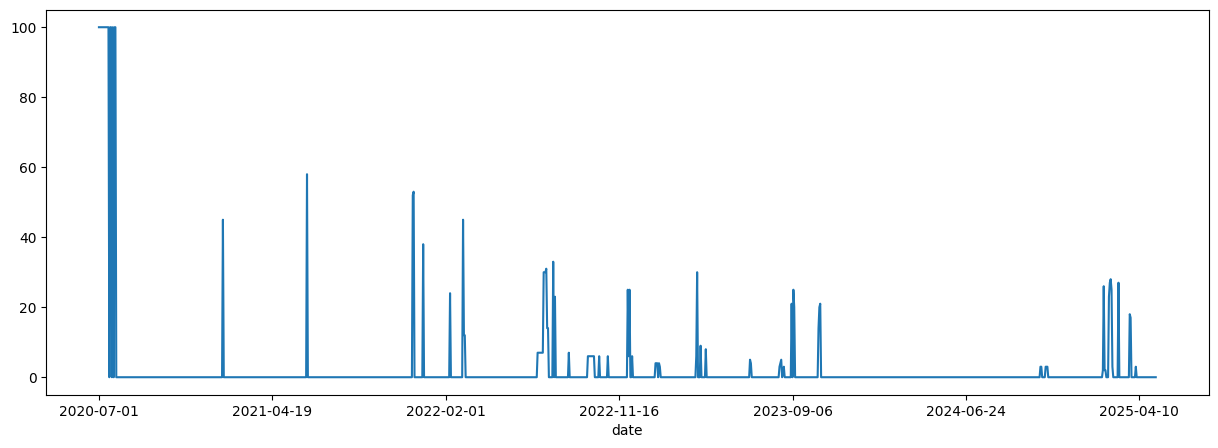

In [ ]:
df_actions_a2c.WMT.plot()

In [ ]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


In [ ]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [ ]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

hit end!


In [ ]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!


# Part 3: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [ ]:
def process_df_for_mvo(df):
  return df.pivot(index="date", columns="tic", values="close")

### Helper functions for mean returns and variance-covariance matrix

In [ ]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai
# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

### Calculate the weights for mean-variance

In [ ]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[ 88.48501587, 220.26594543,  88.49398804, ...,  40.97863007,
         31.70895576,  37.14975357],
       [ 88.48501587, 222.95968628,  88.75744629, ...,  41.06857681,
         32.56217575,  37.00077057],
       [ 90.852005  , 221.24157715,  90.87450409, ...,  41.40588379,
         33.47744751,  36.90145111],
       ...,
       [195.99298096, 275.83999634, 276.23999023, ...,  43.88999939,
         11.05000019,  98.59162903],
       [197.23136902, 272.04998779, 283.66000366, ...,  43.61000061,
         11.15999985,  97.19499969],
       [198.27000427, 265.85998535, 284.51000977, ...,  43.61000061,
         11.22000027,  96.72000122]])

In [ ]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.136 0.068 0.086 0.083 0.066 0.134 0.06  0.035 0.072 0.056 0.103 0.073
 0.033 0.076 0.047 0.073 0.042 0.056 0.054 0.056 0.103 0.089 0.041 0.053
 0.104 0.11  0.044 0.042 0.042]
Variance-Covariance matrix of returns
 [[3.156 1.066 1.768 1.669 1.722 1.814 1.569 1.302 1.302 1.811 1.303 1.432
  1.218 1.674 0.74  1.839 0.719 0.884 1.241 0.823 1.561 1.324 0.752 1.027
  1.298 1.466 0.657 1.078 0.631]
 [1.066 2.571 1.306 1.123 1.193 1.319 1.116 1.053 1.045 1.269 1.068 1.089
  0.899 1.218 0.926 1.391 0.682 0.727 1.025 1.156 1.166 0.984 0.798 0.956
  1.259 1.111 0.688 1.091 0.682]
 [1.768 1.306 4.847 2.73  2.6   2.128 1.944 2.141 2.17  3.142 1.932 2.283
  1.56  2.012 0.993 3.707 1.094 1.319 1.845 1.236 1.899 1.894 1.041 1.921
  1.823 2.314 0.986 1.421 0.707]
 [1.669 1.123 2.73  4.892 2.363 1.979 1.7   2.115 1.959 2.387 1.773 2.319
  1.571 1.797 0.968 2.597 1.144 1.298 1.643 1.071 1.615 1.775 0.91  1.666
  1.707 1.784 0.82  1.345 0.647]
 [1.722 1.193 2.6 

### Use PyPortfolioOpt

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(len(cleaned_weights_mean))])
mvo_weights

array([424250.,      0.,      0.,      0.,      0., 108650.,      0.,
            0.,      0.,      0., 181450.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,  16960.,
            0.,      0.,      0., 133540., 135150.,      0.,      0.,
            0.])

In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([4785.529,    0.   ,    0.   ,    0.   ,    0.   ,  584.148,
          0.   ,    0.   ,    0.   ,    0.   ,  811.941,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,   86.824,    0.   ,    0.   ,    0.   ,
        485.163,  724.956,    0.   ,    0.   ,    0.   ])

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
date,
2020-07-01,1.001918e+06
2020-07-02,1.004235e+06
2020-07-06,1.023225e+06
2020-07-07,1.014021e+06
2020-07-08,1.029461e+06
...,...
2025-05-05,1.890106e+06
2025-05-06,1.880882e+06
2025-05-07,1.875548e+06


# Part 4: DJIA index

Add DJIA index as a baseline to compare with.

In [ ]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-01-01'
TRADE_START_DATE = '2020-01-01'
TRADE_END_DATE = '2025-05-16'

In [ ]:
import yfinance as yf

In [ ]:
# 다운로드
df_dji = yf.download("^DJI", start=TRADE_START_DATE, end=TRADE_END_DATE)

# 인덱스를 컬럼으로 변환
df_dji = df_dji.reset_index()
df_dji

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,^DJI,^DJI,^DJI,^DJI,^DJI
0,2020-07-01,25734.970703,26019.310547,25713.609375,25879.380859,373180000
1,2020-07-02,25827.359375,26204.410156,25778.119141,25936.449219,349130000
2,2020-07-06,26287.029297,26297.529297,25996.080078,25996.080078,340690000
3,2020-07-07,25890.179688,26174.929688,25866.580078,26172.009766,346820000
4,2020-07-08,26067.279297,26109.490234,25816.250000,25950.060547,337300000
...,...,...,...,...,...,...
1217,2025-05-06,40829.000000,41164.328125,40759.410156,41000.191406,416110000
1218,2025-05-07,41113.968750,41266.910156,40829.289062,40956.078125,533870000
1219,2025-05-08,41368.449219,41773.218750,41167.761719,41312.570312,514850000


In [ ]:
# 기준가로 나눈 정규화 값 (Close 기준)
fst_day = df_dji["Close"].iloc[0]

dji = pd.DataFrame()
dji["date"] = df_dji["Date"]
dji["dji_norm"] = df_dji["Close"].div(fst_day).mul(1_000_000)
dji.set_index("date", inplace=True)

In [ ]:
dji

,dji_norm
date,
2020-07-01,1.000000e+06
2020-07-02,1.003590e+06
2020-07-06,1.021452e+06
2020-07-07,1.006031e+06
2020-07-08,1.012913e+06
...,...
2025-05-06,1.586518e+06
2025-05-07,1.597591e+06
2025-05-08,1.607480e+06


In [ ]:
dji.index = pd.to_datetime(dji.index)
dji.head()

,dij_norm
date,
2020-07-01,1.000000e+06
2020-07-02,1.003590e+06
2020-07-06,1.021452e+06
2020-07-07,1.006031e+06
2020-07-08,1.012913e+06


<a id='4'></a>
# Part 5: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    if if_using_a2c
    else None
)
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
    if if_using_ppo
    else None
)
df_result_td3 = (
    df_account_value_td3.set_index(df_account_value_td3.columns[0])
    if if_using_td3
    else None
)
df_result_sac = (
    df_account_value_sac.set_index(df_account_value_sac.columns[0])
    if if_using_sac
    else None
)

In [ ]:
# 1. 전략별 시리즈를 딕셔너리에 조건부로 추가
result_series = {}

if if_using_a2c:
    result_series["a2c"] = df_result_a2c["account_value"]
if if_using_ddpg:
    result_series["ddpg"] = df_result_ddpg["account_value"]
if if_using_ppo:
    result_series["ppo"] = df_result_ppo["account_value"]
if if_using_td3:
    result_series["td3"] = df_result_td3["account_value"]
if if_using_sac:
    result_series["sac"] = df_result_sac["account_value"]

# 항상 포함하는 시리즈
result_series["mvo"] = MVO_result["Mean Var"]
result_series["dji"] = dji["dji_norm"]  # ← 오타 수정 (dij_norm → dji_norm)

# 2. 모든 인덱스를 datetime으로 통일 + 정렬 (정합성 확보)
for key in result_series:
    s = result_series[key]
    s.index = pd.to_datetime(s.index)
    result_series[key] = s.sort_index()

# 3. concat으로 병합
result = pd.concat(result_series.values(), axis=1)
result.columns = list(result_series.keys())
result

,a2c,ddpg,ppo,td3,sac,mvo,dji
date,,,,,,,
2020-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.001918e+06,1.000000e+06
2020-07-02,1.000316e+06,1.000525e+06,1.000124e+06,1.001056e+06,1.000616e+06,1.004235e+06,1.003590e+06
2020-07-06,1.003272e+06,1.003426e+06,1.001579e+06,1.008814e+06,1.007383e+06,1.023225e+06,1.021452e+06
2020-07-07,1.000177e+06,9.973565e+05,9.992689e+05,9.957361e+05,9.949546e+05,1.014021e+06,1.006031e+06
2020-07-08,1.002810e+06,1.001168e+06,1.000828e+06,1.002018e+06,1.000421e+06,1.029461e+06,1.012913e+06
...,...,...,...,...,...,...,...
2025-05-06,1.999502e+06,1.435120e+06,1.352533e+06,1.823628e+06,1.847882e+06,1.880882e+06,1.586518e+06
2025-05-07,2.015185e+06,1.453741e+06,1.362241e+06,1.832739e+06,1.854914e+06,1.875548e+06,1.597591e+06
2025-05-08,2.032323e+06,1.451400e+06,1.374165e+06,1.843223e+06,1.868403e+06,1.882842e+06,1.607480e+06


Now, everything is ready, we can plot the backtest result.

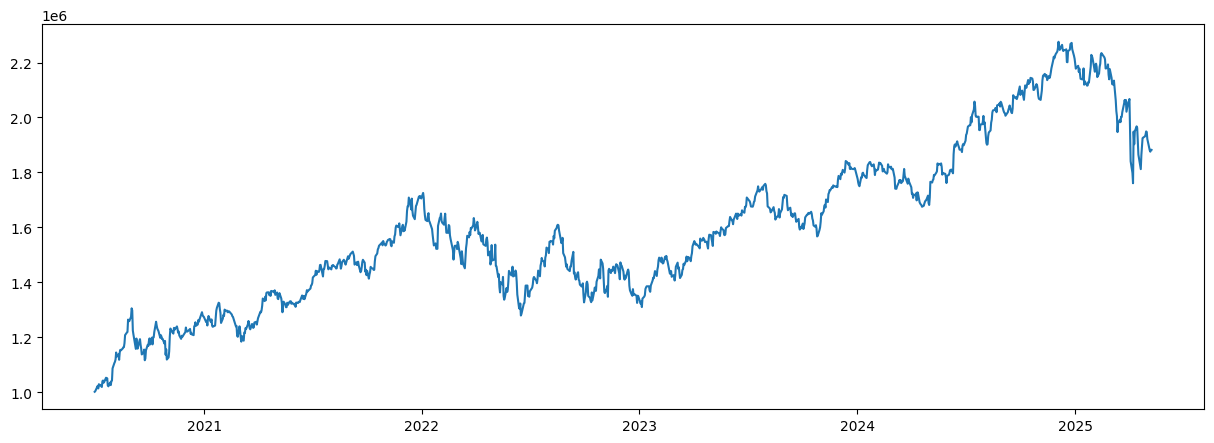

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
plt.plot(result.index, result['mvo'])
plt.show()

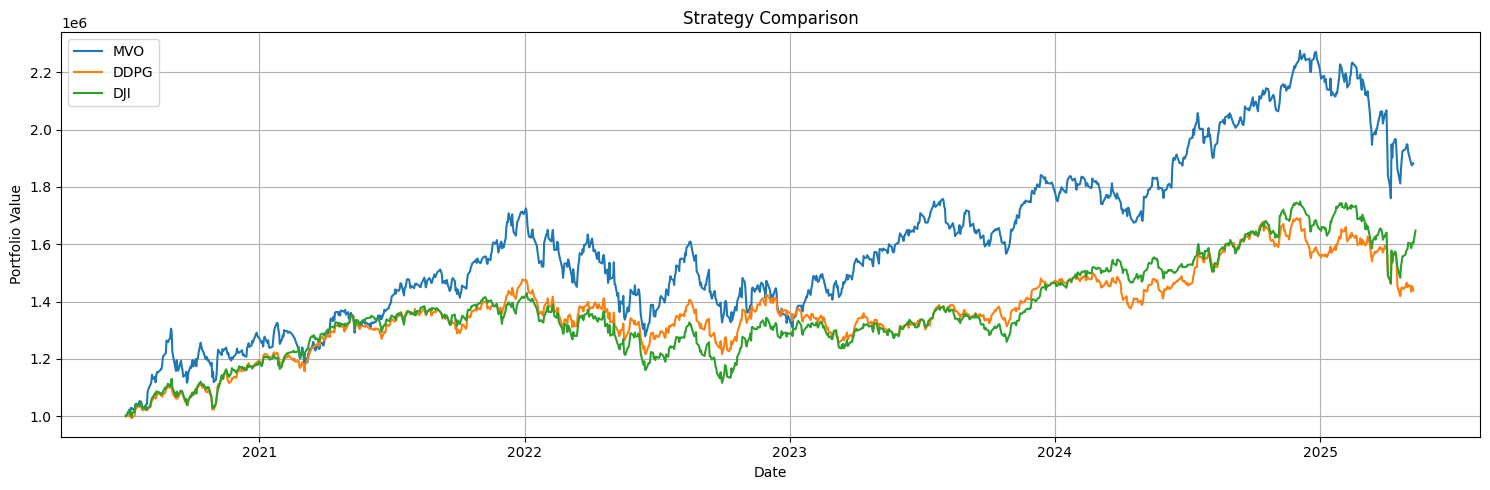

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()

# 각 plot마다 label 명시
plt.plot(result.index, result["mvo"], label="MVO")
plt.plot(result.index, result["ddpg"], label="DDPG")
plt.plot(result.index, result["dji"], label="DJI")

# 범례 위치 및 표시
plt.legend(loc="upper left")
plt.title("Strategy Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

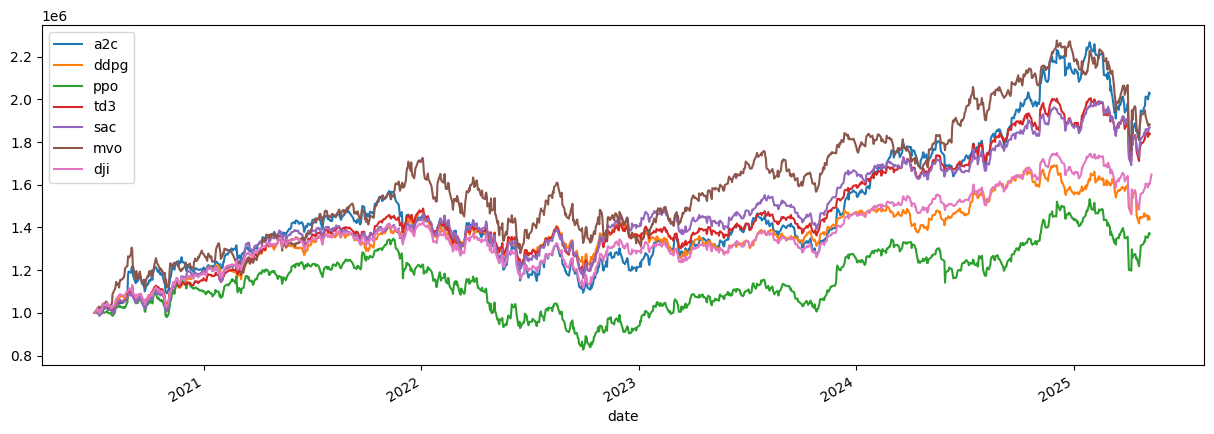

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

In [ ]:
# 필요한 모듈 재임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 재정의 (파일 업로드 후 초기화 되었기 때문에)
# result 데이터프레임은 사용자가 이전에 명시한 형식이라고 가정
# 아래는 예시적인 접근이며, 실제 분석을 위해 CSV 또는 DataFrame 업로드 필요

# 예시를 위해 placeholder 데이터 생성 (실제 데이터 업로드 필요)
# 여기에선 구조만 따라감

# 리스크 지표 계산 함수 재정의
def calculate_risk_metrics(df, annualization=252):
    metrics = {}
    for col in df.columns:
        series = df[col]
        daily_returns = series.pct_change().dropna()
        
        cum_return = series.iloc[-1] / series.iloc[0] - 1
        annual_return = (1 + cum_return) ** (annualization / len(series)) - 1
        annual_vol = daily_returns.std() * np.sqrt(annualization)
        sharpe = annual_return / annual_vol if annual_vol != 0 else np.nan
        
        downside_returns = daily_returns[daily_returns < 0]
        downside_std = downside_returns.std() * np.sqrt(annualization)
        sortino = annual_return / downside_std if downside_std != 0 else np.nan
        
        running_max = series.cummax()
        drawdown = (series - running_max) / running_max
        mdd = drawdown.min()

        metrics[col] = {
            "Annual Return": annual_return,
            "Annual Volatility": annual_vol,
            "Sharpe Ratio": sharpe,
            "Sortino Ratio": sortino,
            "Max Drawdown": mdd
        }
    return pd.DataFrame(metrics).T


In [ ]:
result_drop = result.dropna()
result_drop

,a2c,ddpg,ppo,td3,sac,mvo,dji
date,,,,,,,
2020-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.001918e+06,1.000000e+06
2020-07-02,1.000316e+06,1.000525e+06,1.000124e+06,1.001056e+06,1.000616e+06,1.004235e+06,1.003590e+06
2020-07-06,1.003272e+06,1.003426e+06,1.001579e+06,1.008814e+06,1.007383e+06,1.023225e+06,1.021452e+06
2020-07-07,1.000177e+06,9.973565e+05,9.992689e+05,9.957361e+05,9.949546e+05,1.014021e+06,1.006031e+06
2020-07-08,1.002810e+06,1.001168e+06,1.000828e+06,1.002018e+06,1.000421e+06,1.029461e+06,1.012913e+06
...,...,...,...,...,...,...,...
2025-05-05,2.011779e+06,1.454650e+06,1.351414e+06,1.842011e+06,1.860380e+06,1.890106e+06,1.601666e+06
2025-05-06,1.999502e+06,1.435120e+06,1.352533e+06,1.823628e+06,1.847882e+06,1.880882e+06,1.586518e+06
2025-05-07,2.015185e+06,1.453741e+06,1.362241e+06,1.832739e+06,1.854914e+06,1.875548e+06,1.597591e+06


In [ ]:
# 'dji'는 NaN이 많으므로 제외하고 나머지 전략만 분석
strategy_cols = ["a2c", "ddpg", "ppo", "td3", "sac", "mvo",'dji']

# 리스크 지표 재계산
real_risk_metrics = calculate_risk_metrics(result_drop[strategy_cols])

In [ ]:
real_risk_metrics.T['mvo']

Annual Return        0.138971
Annual Volatility    0.213118
Sharpe Ratio         0.652084
Sortino Ratio        0.947346
Max Drawdown        -0.258570
Name: mvo, dtype: float64

In [ ]:
real_risk_metrics*100

,Annual Return,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
a2c,15.681133,19.654833,79.782581,114.894462,-30.347126
ddpg,7.797124,15.218765,51.233619,72.840377,-17.693875
ppo,6.714651,20.853142,32.199711,44.930183,-38.572339
td3,13.378831,15.250931,87.724683,124.997934,-20.567237
sac,13.767149,16.873130,81.592148,116.779066,-20.688365
mvo,13.897106,21.311847,65.208360,94.734632,-25.857013
dji,10.226914,15.299931,66.842879,94.331621,-21.940804


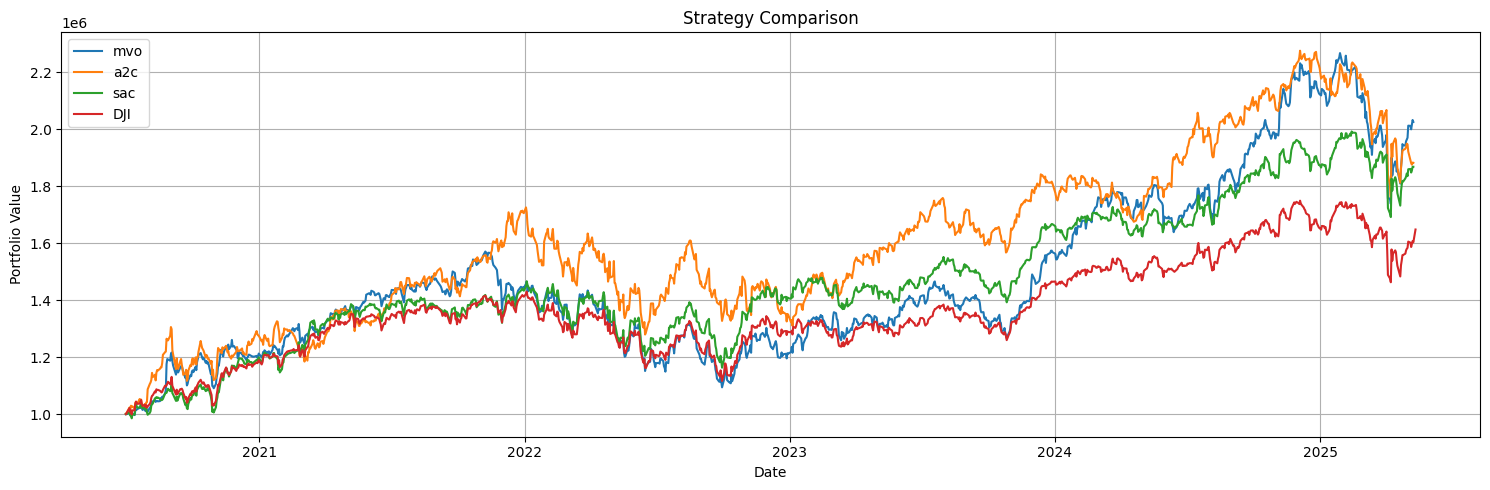

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()

# 각 plot마다 label 명시
plt.plot(result.index, result["a2c"], label="mvo")
plt.plot(result.index, result["mvo"], label="a2c")
plt.plot(result.index, result["sac"], label="sac")
plt.plot(result.index, result["dji"], label="DJI")

# 범례 위치 및 표시
plt.legend(loc="upper left")
plt.title("Strategy Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
real_risk_metrics = real_risk_metrics.sort_values(by= 'Annual Return',ascending=False)
real_risk_metrics*100

,Annual Return,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
a2c,15.681133,19.654833,79.782581,114.894462,-30.347126
mvo,13.897106,21.311847,65.208360,94.734632,-25.857013
sac,13.767149,16.873130,81.592148,116.779066,-20.688365
td3,13.378831,15.250931,87.724683,124.997934,-20.567237
dji,10.226914,15.299931,66.842879,94.331621,-21.940804
ddpg,7.797124,15.218765,51.233619,72.840377,-17.693875
ppo,6.714651,20.853142,32.199711,44.930183,-38.572339


# ✅ 종합 평가

- 알고리즘	종합평가
- td3	수익, 리스크, Sharpe/Sortino 모두 우수. 전반적으로 가장 균형 잡힌 성과
- a2c	수익률은 최고지만, 변동성과 낙폭이 커 리스크 있음
- sac	안정성과 수익률 모두 우수한 편
- ddpg	리스크 낮고 손실 적음. 다소 낮은 수익률이 단점
- ppo	대부분 지표에서 가장 낮은 성과
- mvo	전통적 자산 배분 전략으로 평균적 성과
- dji	기준 벤치마크로서, 일부 DRL 알고리즘이 이를 능가하고 있음

In [ ]:
real_risk_metrics*100 - real_risk_metrics.T['dji']*100

,Annual Return,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
a2c,5.454219,4.354902,12.939703,20.562842,-8.406322
ddpg,-2.429790,-0.081166,-15.609260,-21.491243,4.246929
ppo,-3.512263,5.553211,-34.643168,-49.401438,-16.631535
td3,3.151916,-0.049000,20.881804,30.666314,1.373567
sac,3.540235,1.573199,14.749269,22.447445,1.252439
mvo,3.670192,6.011916,-1.634519,0.403011,-3.916209
dji,0.000000,0.000000,0.000000,0.000000,0.000000
